# Install StellarGraph


In [ ]:
!pip install stellargraph

In [1]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

# Read JSON files

do premennej `graphsRaw` sa nacitaju vsetky grafy z datasetu

`graphsRaw`:
  - `filename`: nazov .lua suboru z ktoreho je vytvoreny
  - `isTest`: 1 ak je to "testovaci" subor, inak 0
  - `isSpec`: 1 ak je to testovaci subor, inak 0
  - `nodes`: DataFrame(columns=\['id', 'type'\])
  - `edges`: DataFrame(columns=\['from', 'to'\])



In [2]:
import os
import pandas as pd
import json
from tqdm.notebook import tnrange # loading bar

dataPath = '../data'
graphsRaw = []
dirs = os.listdir(dataPath)
nDirs = len(dirs)

for i in tnrange(nDirs, desc='Dataset loading'):
    dirname = dirs[i]
    dirPath = dataPath + '/' + dirname
    for filename in os.listdir(dirPath):
        json_file = dirPath + '/' + filename
        with open(json_file) as jf:
            graph = {}
            try:
                jsonData = json.load(jf)
                graph['filename'] = jsonData['_filename']
                graph['isTest'] = int(jsonData['_isTest'])
                graph['isSpec'] = int(jsonData['_isSpec'])
                graph['nodes'] = pd.DataFrame(jsonData['nodes'], columns=['id', 'type'])
                graph['nodes'] = graph['nodes'].set_index('id')
                graph['edges'] = pd.DataFrame(jsonData['edges'], columns=['from', 'to'])
                graphsRaw.append(graph)
            except:
                print(f'Wrong json file: {json_file}')

Dataset loading:   0%|          | 0/1515 [00:00<?, ?it/s]

Wrong json file: ../data/lua-path/test_wcs.lua.json
Wrong json file: ../data/pop3/test-message.lua.json
Wrong json file: ../data/rkeys/rkeys.lua.json
Wrong json file: ../data/stacktraceplus/StackTracePlus.lua.json


# OneHot

kazdemu grafu z `graphsRaw` sa prida atribut `encNodeTypes` (OneHot kodovanie typov uzlov)
- `encNodeTypes` je DataFrame OneHot kodovani pre vsetky uzly v danom grafe
- **typy uzlov**: *\['require container', 'function', 'local variable', 'file', 'tableconstructor', 'module', 'statement:keyword', 'variable container', 'statement:numericfor', 'statement:genericfor', 'statement:if', 'global function', 'statement:functioncall', 'statement:assign', 'function container', 'statement:localassign', 'global variable', 'statement:globalfunction', 'statement:while', 'statement:localfunction', 'interface container', 'interface', 'require local variable', 'statement:do', 'statement:repeat'\]*
- ostatne typy uzlov sa ignoruju

In [3]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ntypes = ['require container', 'function', 'local variable', 'file', 
          'tableconstructor', 'module', 'statement:keyword', 
          'variable container', 'statement:numericfor', 'statement:genericfor', 
          'statement:if', 'global function', 'statement:functioncall', 
          'statement:assign', 'function container', 'statement:localassign', 
          'global variable', 'statement:globalfunction', 'statement:while', 
          'statement:localfunction', 'interface container', 'interface', 
          'require local variable', 'statement:do', 'statement:repeat']

enc = OneHotEncoder(handle_unknown='ignore')
X = np.array(ntypes).reshape(-1,1)
enc.fit(X)

# encode all NodeTypes in graph
for gr in graphsRaw:
    encoded = enc.transform(gr['nodes']['type'].values.reshape(-1,1))
    gr['encNodeTypes'] = pd.DataFrame(encoded.toarray())

In [4]:
graphsRaw[0]['encNodeTypes']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create dataset

dataset tvoria `graphs` a `graph_labels`
- `graphs` je list of StellarGraph
- `graph_labels` je oznacenie daneho grafu pre atribut `isTest`

In [216]:
from stellargraph import StellarGraph

def createStellarGraph(graphRaw):
    nodes = graphRaw['encNodeTypes']
    edges = graphRaw['edges']
    graph = StellarGraph(nodes=nodes, edges=edges, source_column='from', target_column='to', is_directed=True)
    return graph


graphs = [createStellarGraph(gr) for gr in graphsRaw]
#graph_labels = pd.Series([1 if gr['isSpec'] else 2 if gr['isTest'] else 0 for gr in graphsRaw], dtype="category", name='label')
graph_labels = pd.Series([1 if gr['isSpec'] or gr['isTest'] else 0 for gr in graphsRaw], dtype="category", name='label')

# Dataset stats

In [217]:
print(graph_labels.value_counts())

0    6439
1     758
Name: label, dtype: int64


In [218]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,7197.0,7197.0
mean,103.3,175.5
std,165.1,827.3
min,5.0,4.0
25%,28.0,34.0
50%,58.0,79.0
75%,118.0,175.0
max,4025.0,64311.0


# Fit dataset to 1:1
z datasetu sa vyberie len nejaky pocet grafov tak aby sa pocty grafov vytvorenych z testovacich a grafov vytvorenych z netestovacich suborov rovnal 

In [219]:
import random
import numpy as np

noTests, tests = [], []
for idx, d in enumerate(graph_labels):
    if d == 1:
        tests.append(idx)
    elif d == 0:
        noTests.append(idx)

SIZE = 200

resampledNoTests = random.sample(noTests, SIZE)
resampledTests = random.sample(tests, SIZE)
finalIdxs = np.random.choice(np.concatenate([resampledTests, resampledNoTests]), SIZE*2, replace=False)
final_graphs, final_graph_labels = [], []
for i in finalIdxs:
    final_graphs.append(graphs[i])
    final_graph_labels.append(graph_labels[i])
final_graph_labels = pd.Series(final_graph_labels, dtype="category", name='label')

In [220]:
graphs, graph_labels = final_graphs, final_graph_labels

# Show statistics

In [221]:
print(graphs[0].info())

StellarGraph: Directed multigraph
 Nodes: 92, Edges: 130

 Node types:
  default: [92]
    Features: float32 vector, length 25
    Edge types: default-default->default

 Edge types:
    default-default->default: [130]
        Weights: all 1 (default)
        Features: none


In [222]:
print(graphs[1].info())

StellarGraph: Directed multigraph
 Nodes: 8, Edges: 7

 Node types:
  default: [8]
    Features: float32 vector, length 25
    Edge types: default-default->default

 Edge types:
    default-default->default: [7]
        Weights: all 1 (default)
        Features: none


In [223]:
graph_labels.value_counts().to_frame()

,label
0,6439
1,1


In [224]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,6440.0,6440.0
mean,105.6,174.2
std,165.5,860.0
min,5.0,4.0
25%,29.0,34.0
50%,60.0,80.0
75%,121.0,177.0
max,4025.0,64311.0


# Prepair generator

In [225]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [226]:
from stellargraph.mapper import PaddedGraphGenerator
generator = PaddedGraphGenerator(graphs=graphs)

# Supervised graph classification with GCN [StellarGraph]

In [27]:
from stellargraph.layer import GCNSupervisedGraphClassification

from sklearn import model_selection

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [28]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

In [30]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [32]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

In [37]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [45]:
train_gen, test_gen = get_generators(
        train_graphs.index, test_graphs.index, graph_labels, batch_size=30
    )

In [46]:
model = create_graph_classification_model(generator)

In [ ]:
epochs = 100

In [47]:
history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=1, callbacks=[es],
    )

test_metrics = model.evaluate(test_gen, verbose=0)
test_acc = test_metrics[model.metrics_names.index("acc")]

Epoch 1/100
12/12 [==============================] - 11s 884ms/step - loss: 0.6944 - acc: 0.4945 - val_loss: 0.6808 - val_acc: 0.5750
Epoch 2/100
12/12 [==============================] - 5s 468ms/step - loss: 0.6603 - acc: 0.6846 - val_loss: 0.6414 - val_acc: 0.6750
Epoch 3/100
12/12 [==============================] - 6s 512ms/step - loss: 0.5741 - acc: 0.7382 - val_loss: 0.6317 - val_acc: 0.7500
Epoch 4/100
12/12 [==============================] - 6s 518ms/step - loss: 0.5059 - acc: 0.7710 - val_loss: 0.6260 - val_acc: 0.6750
Epoch 5/100
12/12 [==============================] - 6s 553ms/step - loss: 0.4895 - acc: 0.7461 - val_loss: 0.6526 - val_acc: 0.6000
Epoch 6/100
12/12 [==============================] - 6s 421ms/step - loss: 0.5033 - acc: 0.7667 - val_loss: 0.6403 - val_acc: 0.6250
Epoch 7/100
12/12 [==============================] - 6s 443ms/step - loss: 0.4592 - acc: 0.7864 - val_loss: 0.6432 - val_acc: 0.6500
Epoch 8/100
12/12 [==============================] - 6s 492ms/step -

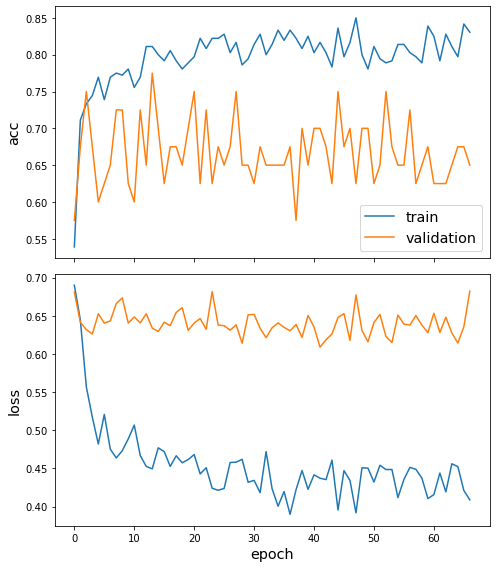

In [48]:
sg.utils.plot_history(history)

In [50]:
print(test_acc)

0.699999988079071


In [227]:
graph_labels

,1
0,0
1,0
2,0
3,0
4,0
...,...
6435,0
6436,0
6437,0
6438,0


In [228]:
test_gen = generator.flow(
        np.arange(0, graph_labels.size), targets=graph_labels.values, batch_size=1
    )

In [230]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

6440/6440 [==============================] - 18s 3ms/step - loss: 0.3772 - acc: 0.8851

Test Set Metrics:
	loss: 0.3772
	acc: 0.8851


# End-to-End classification with trained model

In [156]:
import pandas as pd
import json

def readGraph(path):
    graph = {}
    with open(path) as jsonFile:
        jsonData = json.load(jsonFile)
        graph['filename'] = jsonData['_filename']
        graph['isTest'] = int(jsonData['_isTest'])
        graph['isSpec'] = int(jsonData['_isSpec'])
        graph['nodes'] = pd.DataFrame(jsonData['nodes'], columns=['id', 'type'])
        graph['nodes'] = graph['nodes'].set_index('id')
        graph['edges'] = pd.DataFrame(jsonData['edges'], columns=['from', 'to'])
        graphsRaw.append(graph)
    return graph

In [157]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def encodeNodeTypes(graph):
    ntypes = ['require container', 'function', 'local variable', 'file', 
            'tableconstructor', 'module', 'statement:keyword', 
            'variable container', 'statement:numericfor', 'statement:genericfor', 
            'statement:if', 'global function', 'statement:functioncall', 
            'statement:assign', 'function container', 'statement:localassign', 
            'global variable', 'statement:globalfunction', 'statement:while', 
            'statement:localfunction', 'interface container', 'interface', 
            'require local variable', 'statement:do', 'statement:repeat']

    enc = OneHotEncoder(handle_unknown='ignore')
    X = np.array(ntypes).reshape(-1,1)
    enc.fit(X)
    encoded = enc.transform(graph['nodes']['type'].values.reshape(-1,1))
    graph['encNodeTypes'] = pd.DataFrame(encoded.toarray())

In [158]:
from stellargraph import StellarGraph

def createStellarGraph(graph):
    nodes = graph['encNodeTypes']
    edges = graph['edges']
    label = graph['isSpec'] or graph['isTest']
    stellGraph = StellarGraph(nodes=nodes, edges=edges, source_column='from', target_column='to', is_directed=True)
    return stellGraph, label

In [179]:
from stellargraph.mapper import PaddedGraphGenerator

def makePrediction(path):
    graph = readGraph(path)
    encodeNodeTypes(graph)
    stellGraph, label = createStellarGraph(graph)
    generator = PaddedGraphGenerator(graphs=[stellGraph])
    x = generator.flow(graphs=[stellGraph])
    return model.predict(x)[0][0]

In [183]:
makePrediction('../data/_TEST/_testsource.lua.json')

0.9123748

In [182]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [155]:
import sys
tensor = model.get_layer(index=0).input
print(tensor)
#tf.print(tensor, output_stream=sys.stdout)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 25), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")


In [118]:
output = x
listOutputs = []
for i in range(11):
    #print(output)
    #output = model.get_layer(index=i).compute_mask(output)
    #listOutputs.append(output)
    print(model.get_layer(index=i))

# Hidden

In [3]:
uniquelist = []
for d in graphsRaw:
    curr_list = d['nodes']['type'].unique()
    uniquelist += list(set(curr_list) - set(uniquelist))

In [4]:
print(len(uniquelist))
print(uniquelist)

36
['function container', 'statement:if', 'local variable', 'blank lines', 'variable container', 'statement:genericfor', 'statement:keyword', 'statement:localassign', 'module', 'statement:assign', 'interface', 'file', 'interface container', 'require container', 'global variable', 'statement:while', 'n/a', 'statement:functioncall', 'global function', 'tableconstructor', 'function', 'table assign node', 'require local variable', 'string', 'statement:numericfor', 'number', 'statement:localfunction', '_simpleexp', 'statement:globalfunction', 'keyword', 'symbol', 'statement:repeat', 'unop', 'boolean', '_prefixexp', 'statement:do']


# Visualize graphs

In [ ]:
from graphviz import Digraph

for _, d in enumerate(data):
  nodes_data = data[623]['nodes']
  edges_data = data[623]['edges']

  dot = Digraph(format='png')
  for index, row in nodes_data.iterrows():
    dot.node(str(row.id), str(row['type']), shape='box') # + '\n' + str(row.text)
  for index, row in edges_data.iterrows():
    dot.edge(str(row['from']), str(row['to'])) #, label=row['label']
  dot.render('graphVisualizations/' + data[623]['filename'])
  # TODO
  if _ >= 0:
    break 